# Breast cancer PSI-MS - Subtyping

Import packages

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn import feature_selection
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.model_selection import StratifiedKFold
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pickle
import seaborn as sns

In [33]:
def performance(diagnosis,prediction):
    result=confusion_matrix(diagnosis,prediction)
    tn,fp,fn,tp=result.ravel()
    accuracy=(tp+tn)/np.sum(result)
    specificity=tn/sum(result[0,:])
    sensitivity=tp/sum(result[1,:])
    #print('Accuracy: %.3f Sensitivity: %.3f Specificity: %.3f'%(accuracy,sensitivity,specificity))
    return accuracy, specificity, sensitivity

def C_optimization(C_all, weight, cv, x, y):
    result_c=[]
    for c in C_all:
        svc=svm.SVC(C=c, kernel='linear',class_weight=weight)
        cv_prediction=model_selection.cross_val_predict(svc,x,y,cv=cv)
        accuracy, specificity, sensitivity=performance(y,cv_prediction)
        result_c.append([c, accuracy, specificity, sensitivity])

    df_results_c = pd.DataFrame(result_c, columns =['C','Accuracy', 'Specificity', 'Sensitivity'])
    df_results_c.sort_values(by='Accuracy',ascending=False, ignore_index=True,inplace=True)

    return df_results_c

def Feature_optimization(num_start, num_end, C, weight, cv, x, y):
    result_feature=[]

    for i in range(num_start,num_end,10):
        svc=svm.SVC(C=C, kernel='linear',class_weight=weight)
        svc=feature_selection.RFE(svc,n_features_to_select=i)
        cv_prediction=model_selection.cross_val_predict(svc,x,y,cv=cv)
        accuracy, specificity, sensitivity=performance(y,cv_prediction)
        result_feature.append([i, accuracy, specificity, sensitivity])
    df_results_feature = pd.DataFrame(result_feature, columns =['Features','Accuracy', 'Specificity', 'Sensitivity'])
    df_results_feature.sort_values(by=['Accuracy','Features'],ascending=[False,True], ignore_index=True, inplace=True)
    return df_results_feature

def Plot_C_optimization(df_results_c, c, filename):
    fig = go.Figure()

    # Plot trend
    fig.add_trace(go.Scatter(x=df_results_c['C'], y=df_results_c['Sensitivity']*100,name='Sensitivity',
                             line={'color':'#F4A016','width':5},marker={'size':8}))
    fig.add_trace(go.Scatter(x=df_results_c['C'], y=df_results_c['Specificity']*100,name='Specificity',
                             line={'color':'#157B3A','width':5},marker={'size':8}))
    fig.add_trace(go.Scatter(x=df_results_c['C'], y=df_results_c['Accuracy']*100,name='Accuracy',
                             line={'color':'#A63354','width':5},marker={'size':8}))
    fig.add_trace(go.Scatter(x=[c,c], y=[0,100], mode='lines',
                             line={'dash':'dash','color':'black','width':3},showlegend=False))

    # Some aesthetical adjustments to layout
    fig.update_xaxes(type="log")
    fig.update_layout(autosize=False,width=550,height=350,font=dict(size=14), template='simple_white',
                      legend=dict(yanchor="bottom", y=0.05,xanchor="right",x=0.7, bordercolor="Black",borderwidth=1))

    fig.write_image(os.path.join(Path,filename),scale=3)
    plt.close()

def Plot_Feature_optimization(df_results_feature, Feature, filename):
    fig = make_subplots(rows=2, cols=1, vertical_spacing = 0.15, row_heights=[3.5,1])
    cut_interval = [10, 50]

    # Plot trend
    fig.add_trace(go.Scatter(x=df_results_feature['Features'], y=df_results_feature['Sensitivity']*100,name='Sensitivity',
                        line={'color':'#F4A016','width':5},marker={'size':8}), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_results_feature['Features'], y=df_results_feature['Specificity']*100,name='Specificity',
                        line={'color':'#157B3A','width':5},marker={'size':8}), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_results_feature['Features'], y=df_results_feature['Accuracy']*100,name='Accuracy',
                        line={'color':'#A63354','width':5},marker={'size':8}), row=1, col=1)
    fig.add_trace(go.Scatter(x=[Feature,Feature], y=[0,100], mode='lines',
                         line={'dash':'dash','color':'black','width':3},showlegend=False), row=1, col=1)
    fig.add_trace(go.Scatter(x=[Feature,Feature], y=[0,100], mode='lines',
                         line={'dash':'dash','color':'black','width':3},showlegend=False), row=2, col=1)
    # Some aesthetical adjustments to layout
    fig.update_yaxes(range=[cut_interval[1], 80], row=1, col=1)
    fig.update_xaxes(range=[0,250],visible=False, row=1, col=1)
    fig.update_yaxes(range=[0, cut_interval[0]], row=2, col=1)
    fig.update_xaxes(range=[0,250],row=2, col=1)

    fig.update_layout(autosize=False,width=550,height=350,font=dict(size=14), template='simple_white',
                 legend=dict(yanchor="bottom", y=0.05,xanchor="right",x=0.6, bordercolor="Black",borderwidth=1))
    fig.write_image(os.path.join(Path,filename),scale=3)
    plt.close()

def Breast_Subtype(ER, HER2):
    # Return subtype of breast cancer according to the hormone information
    # 0: Luminal, 1: Her2, 2: Triple negative
    if ER:
        result=0
    else:
        if HER2:
            result=1
        else:
            result=2
    return result

Read files

In [3]:
Path = r'D:\Breast Cancer PSIMS\Codes and figures'
Filename = 'Subtype_All.csv'

# Read raw file and patient subtyping info
Raw_data = pd.read_csv(os.path.join(Path,Filename))

Preprocess data

In [4]:
x = Raw_data.iloc[:,5:]
y_HR = Raw_data.iloc[:,1]
y_HER2 = Raw_data.iloc[:,3]

In [5]:
print('-'*50)
# HR
print('Number of HR group: '+str(len(y_HR)))
print('Number of HR positive:　'+str(sum(y_HR)))
print('Number of HR negative:　'+str(len(y_HR)-sum(y_HR)))
print('-'*50)

# HER2
print('Number of HER2 group: '+str(len(y_HER2)))
print('Number of HER2 positive:　'+str(sum(y_HER2)))
print('Number of HER2 negative:　'+str(len(y_HER2)-sum(y_HER2)))
print('-'*50)

--------------------------------------------------
Number of HR group: 145
Number of HR positive:　116
Number of HR negative:　29
--------------------------------------------------
Number of HER2 group: 145
Number of HER2 positive:　36
Number of HER2 negative:　109
--------------------------------------------------


Tuned parameters

In [26]:
C_all = [10,100,500,750,1000,1200,1500,2000,2250,2500,5000,10000]
cv=10

Build model - HR

In [16]:
# Optimize model
Weight = 'balanced'

df_results_c = C_optimization(C_all, Weight, cv, x, y_HR)
c = df_results_c.loc[0,'C']
print('Optimized C: '+str(c))
df_results_c.sort_values(by='C',ascending=True, inplace=True)
Plot_C_optimization(df_results_c, c, 'C optimization_HR.png')
    
df_results_feature = Feature_optimization(10, 250, c, Weight, cv, x, y_HR)
Feature = df_results_feature.loc[0,'Features']
print('Optimized number of features: '+str(Feature))
df_results_feature.sort_values(by='Features',ascending=True, inplace=True)
Plot_Feature_optimization(df_results_feature, Feature, 'N feature optimization_HR.png')

# 5-fold cross validation
svc=svm.SVC(C=c, kernel='linear',class_weight=Weight)
svc=feature_selection.RFE(svc,n_features_to_select=Feature)

cv_prediction_HR=model_selection.cross_val_predict(svc,x, y_HR,cv=cv)
print('10-fold cross validation results:')
acc, spe, sen=performance(y_HR,cv_prediction_HR)
print('Accuracy: %.3f Sensitivity: %.3f Specificity: %.3f'%(acc,sen,spe))

Optimized C: 2500
Optimized number of features: 110
10-fold cross validation results:
Accuracy: 0.814 Sensitivity: 0.802 Specificity: 0.862


Build model - HER2

In [28]:
# Optimize model
Weight={0:0.25,1:0.75}

df_results_c = C_optimization(C_all, Weight, cv, x, y_HER2)
c = df_results_c.loc[0,'C']
print('Optimized C: '+str(c))
df_results_c.sort_values(by='C',ascending=True, inplace=True)
Plot_C_optimization(df_results_c, c, 'C optimization_HER2.png')
    
df_results_feature = Feature_optimization(10, 250, c, Weight, cv, x, y_HER2)
Feature = df_results_feature.loc[0,'Features']
print('Optimized number of features: '+str(Feature))
df_results_feature.sort_values(by='Features',ascending=True, inplace=True)
Plot_Feature_optimization(df_results_feature, Feature, 'N feature optimization_HER2.png')

# 5-fold cross validation
svc=svm.SVC(C=c, kernel='linear',class_weight=Weight)
svc=feature_selection.RFE(svc,n_features_to_select=Feature)

cv_prediction_HER2=model_selection.cross_val_predict(svc,x, y_HER2,cv=cv)
print('10-fold cross validation results:')
acc, spe, sen=performance(y_HER2,cv_prediction_HER2)
print('Accuracy: %.3f Sensitivity: %.3f Specificity: %.3f'%(acc,sen,spe))

Optimized C: 2000
Optimized number of features: 200
10-fold cross validation results:
Accuracy: 0.710 Sensitivity: 0.694 Specificity: 0.716


Subtyping based on previous models

In [44]:
Subtype_prediction_matrix= [[0 for i in range(3)] for j in range(3)]

for i in range(len(Raw_data)):
    correct = Breast_Subtype(y_HR[i], y_HER2[i])
    predict = Breast_Subtype(cv_prediction_HR[i], cv_prediction_HER2[i])
    Subtype_prediction_matrix[correct][predict] = Subtype_prediction_matrix[correct][predict]+1

acc = np.trace(Subtype_prediction_matrix)/len(Raw_data)
sen_luminal = Subtype_prediction_matrix[0][0]/sum(Subtype_prediction_matrix[0][:])
sen_her2 = Subtype_prediction_matrix[1][1]/sum(Subtype_prediction_matrix[1][:])
sen_tn = Subtype_prediction_matrix[2][2]/sum(Subtype_prediction_matrix[2][:])

print('Overall accuracy:  %.3f'%(acc))
print('Luminal sensitivity:  %.3f'%(sen_luminal))
print('HER2 sensitivity:  %.3f'%(sen_her2))
print('Triple negative sensitivity:  %.3f'%(sen_tn))

Overall accuracy:  0.766
Luminal sensitivity:  0.802
HER2 sensitivity:  0.667
Triple negative sensitivity:  0.588


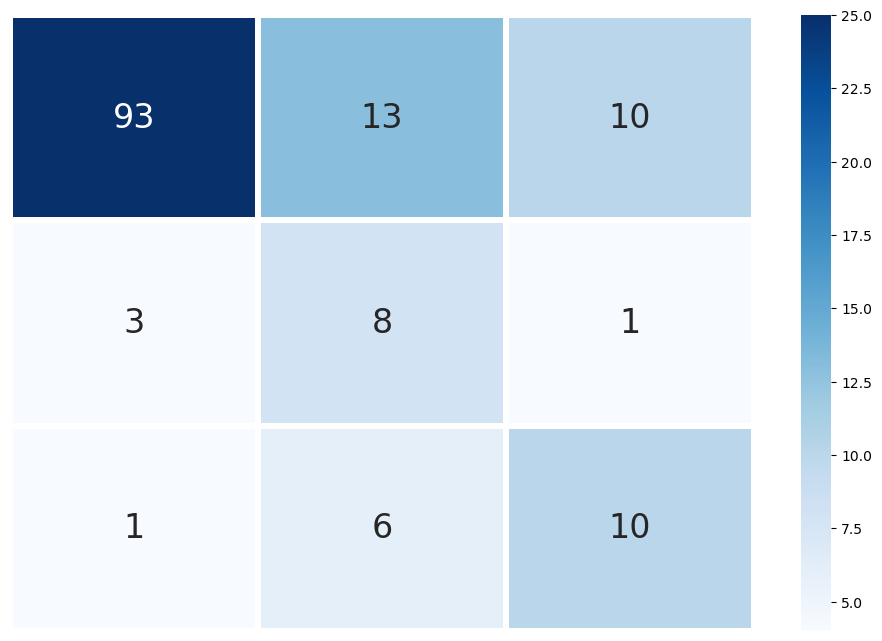

In [64]:
fig = plt.figure(figsize=(12,8)) # Create figure
ax = sns.heatmap(Subtype_prediction_matrix, linewidth=4, vmax=25, vmin=4, annot=True,
                 cmap=sns.color_palette("Blues", as_cmap=True),annot_kws={"fontsize":24},
                 yticklabels=False, xticklabels=False)

#fig.tight_layout()
plt.show()

fig.savefig(os.path.join(Path,'Subtype Heatmap.tif'), dpi=120)
plt.close()